In [1]:
import os
import sys
sys.path.append('./code/')

from utils import *
from DataGenerator import DataGenerator

## Reading Data

In [2]:
image_path = 'flickr8k/images/'
data = pd.read_csv("flickr8k/captions.txt")
data.head()

,image,caption
0,1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set o...
1,1000268201_693b08cb0e.jpg,A girl going into a wooden building .
2,1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .
3,1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playh...
4,1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a woo...


## Visualization

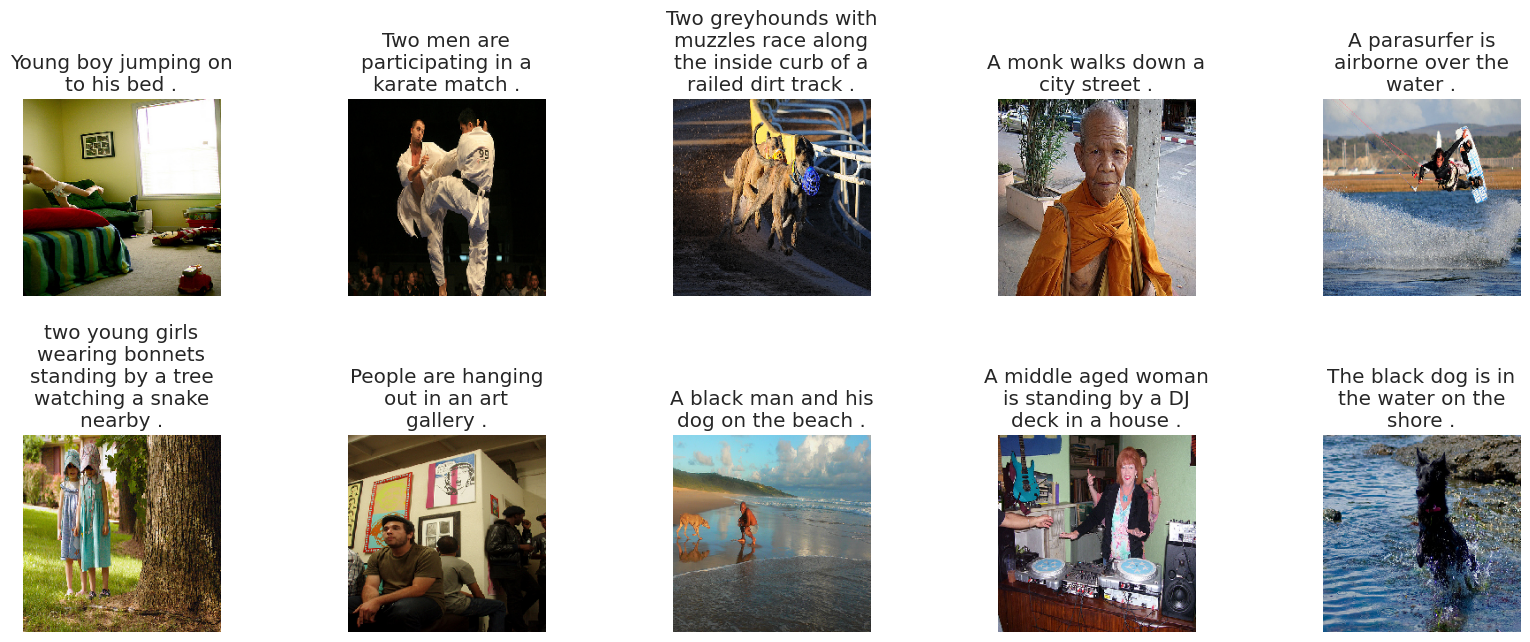

In [3]:
display_images(data.sample(10), path_image = image_path)

## Caption pre-processing

In [4]:
data = text_preprocessing(data)
captions = data['caption'].tolist()
captions[:5]

['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
 'startseq girl going into wooden building endseq',
 'startseq little girl climbing into wooden playhouse endseq',
 'startseq little girl climbing the stairs to her playhouse endseq',
 'startseq little girl in pink dress going into wooden cabin endseq']

## Tokenization and Encoded Representation

In [5]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(captions)
vocab_size = len(tokenizer.word_index) + 1
max_length = max(len(caption.split()) for caption in captions)

## Train-test split

In [6]:
images = data['image'].unique().tolist()
split_index_val = round(0.80 * len(images))

train_images = images[ : split_index_val]
val_images = images[split_index_val : split_index_val + int(0.15 * split_index_val)]
test_images = images[split_index_val + int(0.15 * split_index_val) : ]

train = data[data['image'].isin(train_images)]
train.reset_index(inplace = True, drop = True)

test = data[data['image'].isin(val_images)]
test.reset_index(inplace = True, drop = True)

holdout = data[data['image'].isin(test_images)]
holdout.reset_index(inplace = True, drop = True)

## Image Feature Extraction

In [7]:
model = VGG16()
fe = Model(inputs = model.input, outputs = model.layers[-2].output)

img_size = 224
features = {}
for image in tqdm(data['image'].unique().tolist()):
    img = load_img(os.path.join(image_path,image), target_size = (img_size, img_size))
    img = img_to_array(img)
    img = img/255.
    img = np.expand_dims(img, axis=0)
    feature = fe.predict(img, verbose=0)
    features[image] = feature
    # print(feature.shape)
    # break

  0%|          | 0/8091 [00:00<?, ?it/s]

## Modelling

In [10]:
input1 = Input(shape = (4096, ))
img_features = Dense(3000, activation = 'relu')(input1)
img_features1 = Dense(512, activation = 'relu')(img_features)
img_features_reshaped = Reshape((1, 512), input_shape = (512,))(img_features1)

input2 = Input(shape = (max_length, ))
sentence_features = Embedding(vocab_size, 512)(input2)

merged = concatenate([img_features_reshaped, sentence_features], axis = 1)

sentence_features = LSTM(512)(merged)
x = Dropout(0.2)(sentence_features)
x = add([x, img_features1])
x = Dense(512, activation = 'relu')(x)
x = Dropout(0.2)(x)
x = Dense(1024, activation = 'relu')(x)
x = Dropout(0.2)(x)

output = Dense(vocab_size, activation = 'softmax')(x)

caption_model = Model(inputs = [input1, input2], outputs = output)
caption_model.compile(loss = 'categorical_crossentropy', optimizer = 'adam')

In [11]:
caption_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 4096)]       0           []                               
                                                                                                  
 dense_4 (Dense)                (None, 3000)         12291000    ['input_5[0][0]']                
                                                                                                  
 dense_5 (Dense)                (None, 512)          1536512     ['dense_4[0][0]']                
                                                                                                  
 input_6 (InputLayer)           [(None, 34)]         0           []                               
                                                                                            

In [12]:
from tensorflow.keras.utils import plot_model

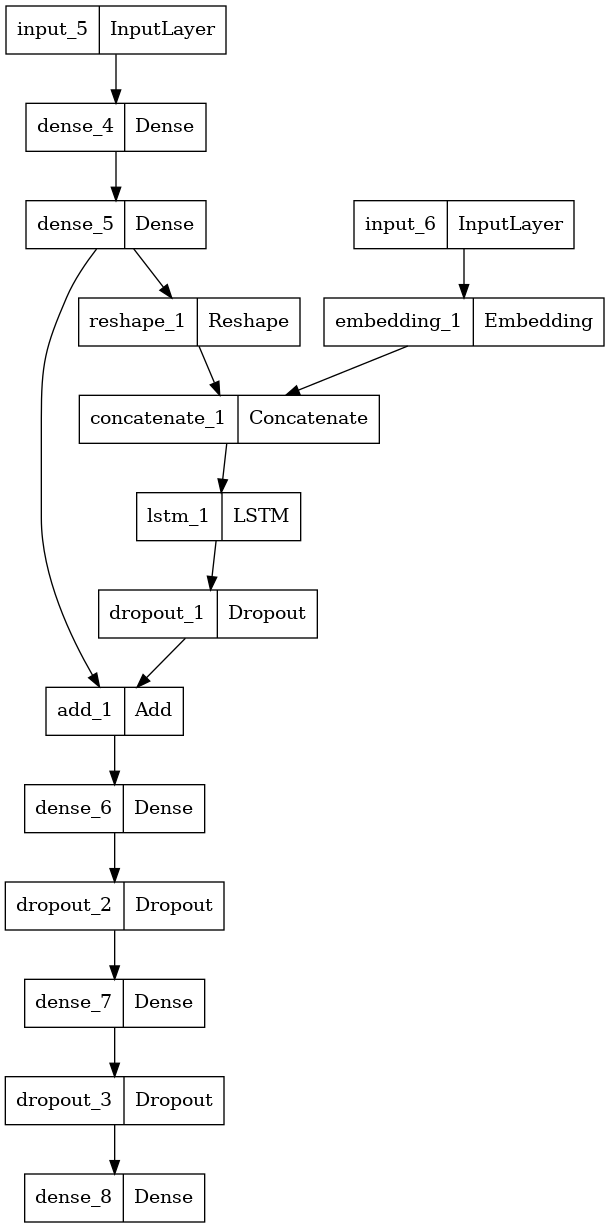

In [13]:
plot_model(caption_model)

In [14]:
train_generator = DataGenerator(df = train, X_col = 'image', y_col = 'caption', 
                                      batch_size = 32, directory = image_path,
                                      tokenizer = tokenizer, vocab_size = vocab_size, max_length = max_length, features = features)

validation_generator = DataGenerator(df = test, X_col = 'image', y_col = 'caption',
                                       batch_size = 32, directory = image_path,
                                       tokenizer = tokenizer, vocab_size = vocab_size, max_length = max_length, features = features)

In [15]:
model_name = "BaselineModel_Final_30k.h5"

checkpoint = ModelCheckpoint(model_name, monitor = "val_loss", mode = "min", save_best_only = True, verbose = 1)
earlystopping = EarlyStopping(monitor = 'val_loss', min_delta = 0, patience = 5, verbose = 1, restore_best_weights = True)
learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', patience = 3, verbose = 1, factor = 0.2, min_lr = 0.00000001)

In [16]:
history = caption_model.fit(
                train_generator, 
                epochs = 30, 
                validation_data = validation_generator,
                callbacks = [checkpoint, earlystopping, learning_rate_reduction]
          )

Epoch 1/30
1011/1011 [==============================] - ETA: 0s - loss: 4.6915
Epoch 1: val_loss improved from inf to 4.06444, saving model to BaselineModel_Final_30k.h5
1011/1011 [==============================] - 1462s 1s/step - loss: 4.6915 - val_loss: 4.0644 - lr: 0.0010
Epoch 2/30
1011/1011 [==============================] - ETA: 0s - loss: 3.8157
Epoch 2: val_loss improved from 4.06444 to 3.77729, saving model to BaselineModel_Final_30k.h5
1011/1011 [==============================] - 409s 404ms/step - loss: 3.8157 - val_loss: 3.7773 - lr: 0.0010
Epoch 3/30
1011/1011 [==============================] - ETA: 0s - loss: 3.5100
Epoch 3: val_loss improved from 3.77729 to 3.69381, saving model to BaselineModel_Final_30k.h5
1011/1011 [==============================] - 418s 414ms/step - loss: 3.5100 - val_loss: 3.6938 - lr: 0.0010
Epoch 4/30
1011/1011 [==============================] - ETA: 0s - loss: 3.3028
Epoch 4: val_loss improved from 3.69381 to 3.65743, saving model to BaselineModel

## Learning Curve

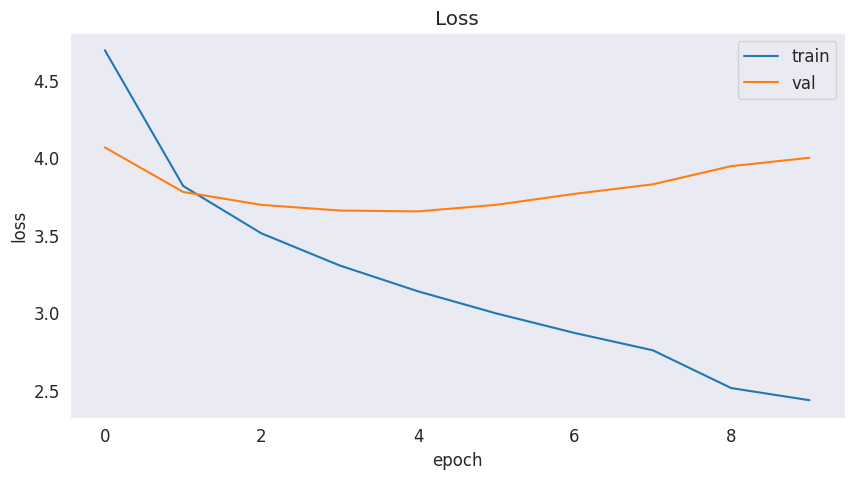

In [17]:
plt.figure(figsize=(10,5))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

## Caption Generation 

In [18]:
def get_predictions_baseline(sample_size, test, image_path, 
                    caption_model, tokenizer, max_length, 
                    features, verbosity = 0):
    
    if(len(test) < sample_size):
        samples = test.sample(sample_size, replace = True)
    else:    
        samples = test.sample(sample_size, replace = False)

    samples.reset_index(drop=True,inplace=True)

    for index,record in samples.iterrows():
        img = load_img(os.path.join(image_path, record['image']),target_size=(224,224))
        img = img_to_array(img)
        img = img/255.
        caption = predict_caption(caption_model, record['image'], 
                                  tokenizer, max_length, features, verbosity)
        samples.loc[index,'caption'] = caption

    display_images(samples, image_path)

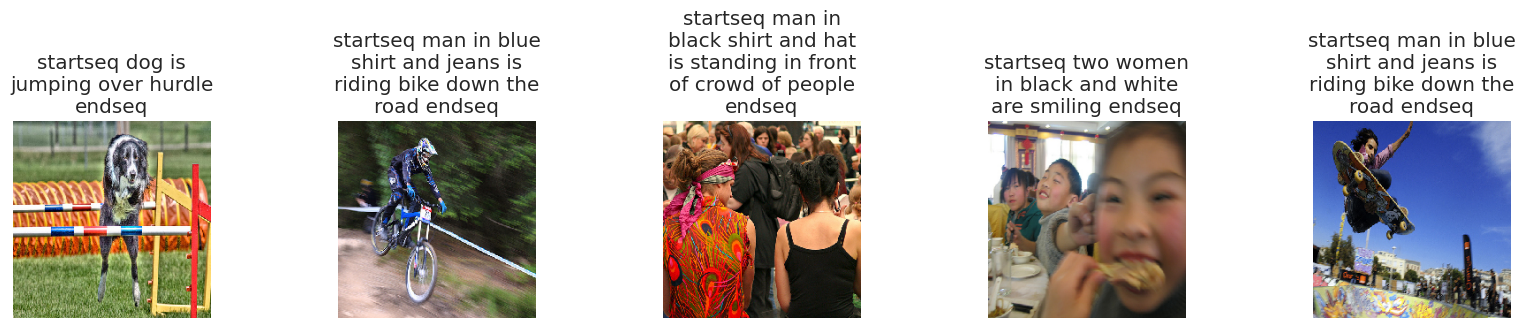

In [22]:
get_predictions_baseline(5, test, image_path, 
                    caption_model, tokenizer, max_length, 
                    features)